In [1]:
# !pip install -U scikit-learn
# !pip install pandas -U
# !pip install numpy -U
!pip install imbalanced-learn -U

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: imbalanced-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.8.1)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
import re
from tqdm import tqdm
from itertools import product

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_validate, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-первичный-просмотр-данных" data-toc-modified-id="Загрузка-и-первичный-просмотр-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и первичный просмотр данных</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Борьба-с-дисбалансом-классов" data-toc-modified-id="Борьба-с-дисбалансом-классов-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Борьба с дисбалансом классов</a></span></li><li><span><a href="#Векторизация-текста" data-toc-modified-id="Векторизация-текста-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Векторизация текста</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisiticRegression" data-toc-modified-id="LogisiticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisiticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LightGBMClassifier" data-toc-modified-id="LightGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBMClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Сентимент анализ комментариев

Представлен набор комментариев различных товаров с сайта интернет-магазина с разметкой о токсичности правок.

**Цель:** Обучить модель классифицировать комментарии на позитивные и негативные.

**Требование от заказчика:** Постройте модель со значением метрики качества *F1* не меньше 0.75. 

# Описание данных

Столбец *text* содержит текст комментария, а *toxic* — целевой признак.

## Подготовка данных

### Загрузка и первичный просмотр данных

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 40)

In [4]:
comments = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
comments.sample(3)

,text,toxic
141852,this guys a fuckin prick and if i ever come cr...,1
158626,Russia\nCareful there. US currently isn't a pa...,0
53044,"""\n\nHurricaneWarning Template\n\nGreeting, My...",0


In [6]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
comments.duplicated().sum()

0

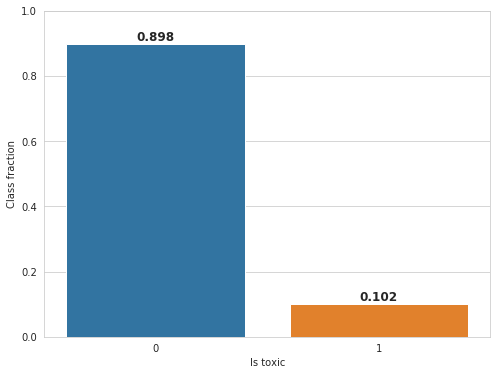

In [8]:
ax, fig = plt.subplots(figsize=(8, 6))
bar = sns.barplot(comments.toxic.value_counts(normalize=True).index, 
                  comments.toxic.value_counts(normalize=True),
                 )

for index, frac in comments.toxic.value_counts(normalize=True).iteritems():
    bar.text(index, 
             frac+0.01, 
             round(frac,3), 
             fontsize=12,
             fontweight='bold',
             ha='center'
            )

plt.xlabel('Is toxic')
plt.ylabel('Class fraction')
plt.ylim([0, 1])
plt.show()

- Как мы видим, у нас наблюдается довольно сильный дисбаланс классов целевого признака
- Подготовим данные, разделим их на обучающую и тестовую выборки, а затем сделаем ресемплирование обучающей выборки, для этого выберем метод SMOTE

### Подготовка признаков

- Подготовим функцию для приведения к нижнему регистру, лемматизации и очистки текста от символов
- Убирая символы, мы также убираем апострофы, меняя смысл части слов на противоположный для слов с отрицанием. Т.к. в сентимент анализе данные изменения не повлияют на результат, в целях упрощения будем убирать апострофы и одинарные кавычки.
- Кроме того, для более точного расчета векторных представлений слов, было бы неплохо провести анализ синонимов, но опять же для сентимент анализа данная операция вероятно не сильно повлияет на результат, поэтому снова для упрощения не будем делать анализ синонимов

In [9]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
def lemmatize_and_clean(text):
    cleaned = []
    corpus = list(text.str.lower())
    wnl = WordNetLemmatizer()
    for i in tqdm(range(len(corpus))):
        text = re.sub(r'[^a-zA-Z ]', ' ', corpus[i])
        lemm_list = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(nltk.word_tokenize(text))]
        lemm_text = ' '.join(lemm_list)
        cleaned.append(lemm_text)
    return cleaned

In [11]:
%%time
cleaned = lemmatize_and_clean(comments['text'])

100%|██████████| 159571/159571 [15:28<00:00, 171.86it/s]

CPU times: user 14min 52s, sys: 11.2 s, total: 15min 4s
Wall time: 15min 28s


In [12]:
comments['text_cleaned'] = cleaned
comments.head(10)

,text,toxic,text_cleaned
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation from me a well use the tool wel...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense be offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


In [13]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
text            159571 non-null object
toxic           159571 non-null int64
text_cleaned    159571 non-null object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


- Зададим отдельно стоп слова из английского языка

In [14]:
import nltk
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Борьба с дисбалансом классов

- Для борьбы с дисбалансом классом будем использовать метод оверсэмплинга SMOTE
- Кроме того, оценим качество модели с помощью кросс-валидации, при этом ресемплировать будем только тренировочную выборку

In [15]:
seed = 24
cv = 3

In [16]:
kf = KFold(n_splits=cv, shuffle=False)

In [36]:
def kfoldcv_score_model(X_train, y_train, model, params, kf=kf, seed=seed):
    
    f1_scores = []
    roc_auc_scores = []
    
    smoter = SMOTE(random_state=seed)

    for train_fold_index, val_fold_index in kf.split(X_train, y_train):
        
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]
        
        tfidf_vec = TfidfVectorizer(stop_words=stopwords)
        tfidf_train = tfidf_vec.fit_transform(X_train_fold['text_cleaned'])
        tfidf_val = tfidf_vec.transform(X_val_fold['text_cleaned'])
        
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(tfidf_train, y_train_fold)
        
        #model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        model_obj = model(**params)
        model_obj.fit(X_train_fold_upsample, y_train_fold_upsample)
        
        model_to_save = model(**params)
        
        f1_scores.append(f1_score(y_val_fold, model_obj.predict(tfidf_val)))
        roc_auc_scores.append(roc_auc_score(y_val_fold, model_obj.predict(tfidf_val)))
        
    return np.array(f1_scores).mean(), np.array(roc_auc_scores).mean(), model_to_save

### Векторизация текста

- Векторизуем текст с помощью техники TF-IDF

In [18]:
X = comments[['text_cleaned']]
y = comments[['toxic']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [19]:
tfidf_vec = TfidfVectorizer(stop_words=stopwords)
tfidf_train = tfidf_vec.fit_transform(X_train['text_cleaned'])
tfidf_test = tfidf_vec.transform(X_test['text_cleaned'])

## Обучение моделей

- Попробуем 4 модели:
    - Логистическую регрессию с class_weight='balanced' и подбором порога
    - Логистическую регрессию с оверсемпингом SMOTE
    - Случайный лес
    - Градиентный бустинг
- К сожалению, не хватает вычислительных мощностей для оценки моделей Случайного леса и Градиентного бустинга с помощью кросс-валидации, поэтому для данных моделей качество будет оценено сразу на тестовой выборке

### LogisiticRegression

**Базовая модель**

In [20]:
%%time
logreg_class_bal = LogisticRegression(class_weight='balanced')
logreg_class_bal.fit(tfidf_train, y_train)

y_pred = logreg_class_bal.predict(tfidf_test)
y_probs = logreg_class_bal.predict_proba(tfidf_test)

CPU times: user 27.6 s, sys: 29.6 s, total: 57.2 s
Wall time: 57.3 s


In [21]:
f1_bal = f1_score(y_test, y_pred)
roc_bal = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])

In [22]:
f1_bal

0.7335329341317366

In [23]:
roc_bal

0.8957977278398471

- Порог для Логистической регрессии подберем с помощью графиков Специфичность (TPR) vs порог и Чувствительность (1-FPR) vs порог: оптимальный порог тот, где данные графики пересекаются

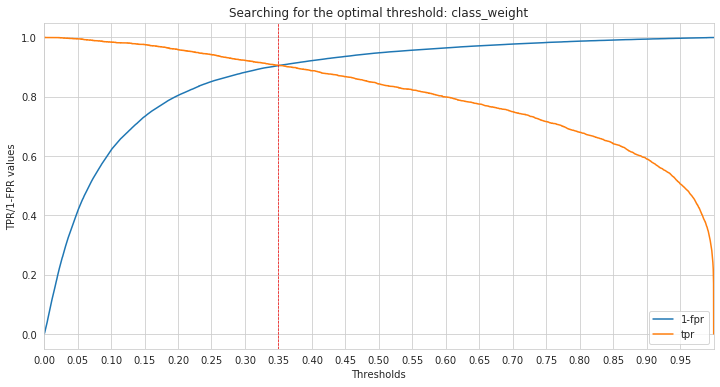

In [24]:
plt.figure(figsize=(12, 6))

plt.plot(thresholds, 1-fpr)
plt.plot(thresholds, tpr)

plt.xlabel('Thresholds')
plt.ylabel('TPR/1-FPR values')

plt.legend(['1-fpr', 'tpr'], loc=4)

plt.xlim([0, 1])
plt.xticks(np.arange(0, 1, step=.05))

plt.axvline(.35, c='r', linestyle='--', linewidth=.7)

plt.title('Searching for the optimal threshold: class_weight')

plt.show()

In [25]:
y_pred_custom = np.where(y_probs[:, 1] > 0.65, 1, 0)

f1_bal_cus = f1_score(y_test, y_pred_custom)
roc_bal_cus = roc_auc_score(y_test, y_pred_custom)

In [26]:
f1_bal_cus

0.7662211421628189

In [27]:
roc_bal_cus

0.8735362532984775

- Выбор порога увеличил значение f1 меры 0.035, f1=0.77, что удовлетворяет условию > 0.75

**Балансировка классов с помощью SMOTE**

In [28]:
hyperparams_logreg = {'C': [0.1, 3, 5]}

In [37]:
%%time

logreg_results = []

for с in hyperparams_logreg['C']:
    
    case_params = {'C': с,
                   'random_state': seed,
                   'solver': 'saga'
                  }

    case_params['f1_val'], case_params['roc_auc_val'], case_params['best_model'] = kfoldcv_score_model(X_train, 
                                                                                                       y_train,
                                                                                                       LogisticRegression,
                                                                                                       case_params
                                                                                                       )
    logreg_results.append(case_params)

CPU times: user 3min, sys: 7.08 s, total: 3min 7s
Wall time: 3min 9s


In [38]:
best_logreg_model = sorted(logreg_results, key=lambda x: x['f1_val'], reverse=True)[0]
best_logreg_model

{'C': 3,
 'random_state': 24,
 'solver': 'saga',
 'f1_val': 0.6908302285638204,
 'roc_auc_val': 0.881764107538595,
 'best_model': LogisticRegression(C=3, random_state=24, solver='saga')}

In [48]:
logreg_best = case_params['best_model']
logreg_best.fit(tfidf_train, y_train)

y_pred_smote = logreg_best.predict(tfidf_test)
y_probs_smote = logreg_best.predict_proba(tfidf_test)

In [49]:
f1_smote = f1_score(y_test, y_pred_smote)
roc_smote = roc_auc_score(y_test, y_pred_smote)

fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_probs_smote[:, 1])

In [50]:
f1_smote

0.7639064032506655

In [51]:
roc_smote

0.8303354816975873

- Значение f1 меры равно 0.76, что удовлетворяет условию > 0.75

### RandomForestClassifier

In [100]:
%%time
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(tfidf_train, y_train)

y_pred_rf = rf.predict(tfidf_test)

CPU times: user 11min 2s, sys: 216 ms, total: 11min 2s
Wall time: 11min 20s


In [101]:
f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_pred_rf)

In [102]:
f1_rf

0.6862745098039216

In [103]:
roc_rf

0.7689350602880455

- Значение f1 меры равно 0.69, что не удовлетворяет условию > 0.75

### LightGBMClassifier

In [104]:
%%time
gb = lgb.LGBMClassifier()
gb.fit(tfidf_train, y_train)

y_pred_gb = gb.predict(tfidf_test)

CPU times: user 8min 5s, sys: 2.12 s, total: 8min 7s
Wall time: 8min 11s


In [105]:
f1_gb = f1_score(y_test, y_pred_gb)
roc_gb = roc_auc_score(y_test, y_pred_gb)

## Выводы

In [108]:
results = pd.DataFrame({'f1': [f1_bal_cus, f1_smote, f1_rf, f1_gb],
                        'roc_auc': [roc_bal, roc_smote, roc_rf, roc_gb]
                       },
                       index=['LogisticRegression_class_weighted', 
                              'LogisticRegression_SMOTE', 
                              'RandomForestClassifier', 
                              'LightGBMClassifier'
                             ]
                      )

results.sort_values(by='f1', ascending=False)

,f1,roc_auc
LogisticRegression_class_weighted,0.766,0.896
LogisticRegression_SMOTE,0.764,0.830
LightGBMClassifier,0.741,0.812
RandomForestClassifier,0.686,0.769


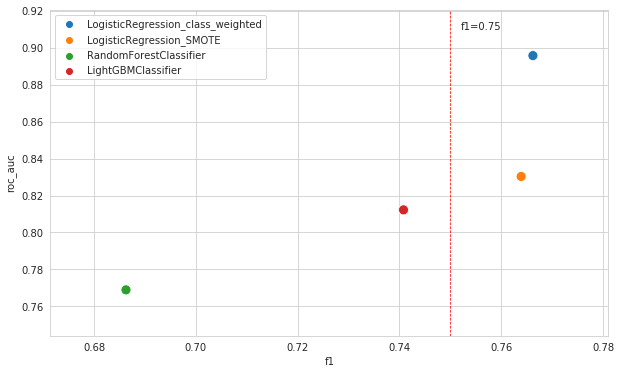

In [114]:
plt.figure(figsize=(10, 6))
sns.scatterplot(results['f1'], results['roc_auc'], hue=results.index, s=100)
plt.axvline(0.75, linestyle='--', c='r', linewidth=0.75)
plt.text(0.752, 0.91, 'f1=0.75')
plt.show()

- Таким образом, лучший результат показала модель Логистической регрессии с использованием внутренней балансировки классов
- Кроме того, результат выше заявленного значения показала модель Логистической регрессии с использованием техники SMOTE
- Остальные модели показали значение метрики f1 ниже 0.75